In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import heapq

import random

In [2]:
def carregar_dados_medicamentos(path_tsv, sucesso_padrao=0.5):
    """
    Lê o arquivo meddra_freq.tsv e retorna um dicionário de medicamentos com efeitos colaterais e sucesso estimado.
    
    Parâmetros:
    - path_tsv: caminho para o arquivo .tsv
    - sucesso_padrao: valor de sucesso a ser atribuído a cada medicamento
    
    Retorno:
    - dicionário no formato:
        {
            'CID...': {
                'efeitos': { 'Efeito1': freq, 'Efeito2': freq, ... },
                'sucesso': sucesso_padrao
            },
            ...
        }
    """
    df = pd.read_csv(path_tsv, sep='\t', header=None)

    # Renomear colunas relevantes
    df.columns = [
        "sider_id", "pubchem_cid", "umls_id", "unknown", 
        "freq_text", "freq_value", "unknown2", "term_type", 
        "umls_id_2", "side_effect"
    ]

    # Filtra apenas termos principais (PT = Preferred Term)
    df_pt = df[df["term_type"] == "PT"]

    # Agrupa por PubChem CID → efeitos colaterais com frequência
    agrupado = df_pt.groupby("pubchem_cid").apply(
        lambda x: dict(zip(x["side_effect"], x["freq_value"]))
    )

    # Monta o dicionário final
    medicamentos = {
        cid: {
            "efeitos": efeitos,
            "sucesso": sucesso_padrao
        }
        for cid, efeitos in agrupado.items()
    }

    return medicamentos

In [3]:
path= "data/meddra_freq.tsv"
medicamentos = carregar_dados_medicamentos(path)

# Visualizar um exemplo
cid_exemplo = random.choice(list(medicamentos.keys()))
print(cid_exemplo)
print(medicamentos[cid_exemplo])

CID016130965
{'efeitos': {'Dyspnoea': 0.0, 'Dermatitis': 0.0, 'Rash': 0.0, 'Headache': 0.001, 'Hypersensitivity': 0.0, 'Nausea': 0.001, 'Swelling': 0.1, 'Swelling face': 0.0, 'Feeling abnormal': 0.001, 'Malaise': 0.001, 'Discomfort': 0.001, 'Ill-defined disorder': 0.001, 'Erythema': 0.1}, 'sucesso': 0.5}


/tmp/ipykernel_13274/181427929.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agrupado = df_pt.groupby("pubchem_cid").apply(


Sequência de tratamento encontrada: ['CID000000137', 'CID000000143']
Custo total (efeitos colaterais acumulados): 0.00


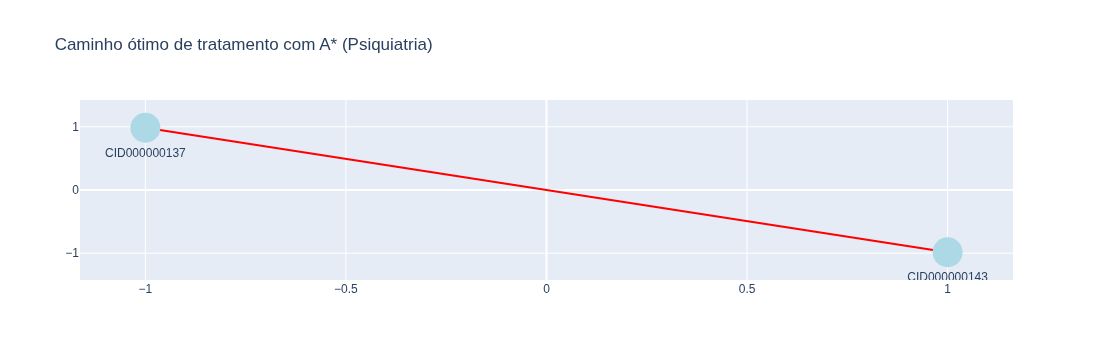

In [4]:
# Importância dos efeitos para o paciente
perfil_paciente = {'Abdominal pain': 0.02, 'Headache': 0.0379404}

# Função para calcular impacto (custo g)
def calcular_impacto(medicamento):
    efeitos = medicamentos[medicamento]["efeitos"]
    score = sum(
        efeitos.get(efeito, 0.0) * peso  # retorna 0.0 se o efeito não estiver no dicionário
        for efeito, peso in perfil_paciente.items()
    )
    return score

# Heurística (quanto falta para 100% de sucesso)
def heuristica(sucesso_acumulado):
    return (1 - sucesso_acumulado)

# A* Search
def a_star_tratamento():
    inicio = ("", 0.0, [], 0.0)  # (último medicamento, sucesso acumulado, caminho, custo total)
    fronteira = []
    heapq.heappush(fronteira, (heuristica(0.0), inicio))

    visitados = set()

    while fronteira:
        prioridade, (ultimo_med, sucesso_acum, caminho, custo_total) = heapq.heappop(fronteira)

        if sucesso_acum >= 0.9:
            print(f"Sequência de tratamento encontrada: {caminho}")
            print(f"Custo total (efeitos colaterais acumulados): {custo_total:.2f}")
            return caminho

        for med in medicamentos:
            if med not in caminho:  # evita repetir o mesmo medicamento
                novo_sucesso = min(sucesso_acum + medicamentos[med]["sucesso"], 1.0)
                impacto = calcular_impacto(med)
                novo_caminho = caminho + [med]
                novo_custo_total = custo_total + impacto

                prioridade = novo_custo_total + heuristica(novo_sucesso)
                estado = (med, novo_sucesso, novo_caminho, novo_custo_total)

                if tuple(novo_caminho) not in visitados:
                    heapq.heappush(fronteira, (prioridade, estado))
                    visitados.add(tuple(novo_caminho))

    return []

# Executa o A* e obtém o caminho ótimo
caminho_otimo = a_star_tratamento()

# Cria grafo com NetworkX
G = nx.DiGraph()
for i in range(len(caminho_otimo) - 1):
    G.add_edge(caminho_otimo[i], caminho_otimo[i+1])

# Posições dos nós
pos = nx.spring_layout(G, seed=42)

# Prepara coordenadas das arestas
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=2, color='red'), mode='lines')

# Prepara coordenadas dos nós
node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    marker=dict(size=30, color='lightblue'),
    textposition="bottom center"
)

# Mostra grafo
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title='Caminho ótimo de tratamento com A* (Psiquiatria)', showlegend=False)
fig.show()